# GON for MNIST

In [33]:
#Import Needed Libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
import imageio
from PIL import Image, ImageDraw, ImageFont

In [34]:
# Define the generator network
class GNet(nn.Module):
    def __init__(self):
        super(GNet, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_maps * 4, 4, 1, 0, bias=True),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ELU(),
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=True),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ELU(),
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=True),
            nn.BatchNorm2d(feature_maps),
            nn.ELU(),
            nn.ConvTranspose2d(feature_maps, channels, 4, 2, 1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


In [35]:
# Utility functions
def infinite_cycle(iterable):
    while True:
        for item in iterable:
            yield item

def spherical_interp(v1, v2, alpha):
    cos_omega = torch.acos((v1 / torch.norm(v1, dim=1, keepdim=True) * v2 / torch.norm(v2, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    sin_omega = torch.sin
    result = (sin_omega((1.0 - alpha) * cos_omega) / sin_omega(cos_omega)) * v1 + (sin_omega(alpha * cos_omega) / sin_omega(cos_omega)) * v2
    return result

def generate_slerp_images(model, latent_vars):
    latent_copy = latent_vars.data.clone().squeeze(-1).squeeze(-1)
    num_cols = int(np.sqrt(latent_vars.size(0)))
    start_z = latent_copy.data[:num_cols].repeat(num_cols, 1)
    z1, z2 = latent_copy.data.split(latent_copy.shape[0] // 2)
    end_z = torch.cat([z2, z1])[:num_cols].repeat(num_cols, 1)
    alpha = torch.linspace(0, 1, num_cols).unsqueeze(1).repeat(1, num_cols).contiguous().view(batch_sz, 1).contiguous().to(device)
    interpolated_z = spherical_interp(start_z, end_z, alpha)
    generated_images = model(interpolated_z.unsqueeze(-1).unsqueeze(-1))
    return generated_images

In [36]:
# Dataset information
data_name = 'mnist'  # ['mnist', 'fashion']
image_size = 32
channels = 1

# Training settings
learning_rate = 1e-4
batch_sz = 64
latent_dim = 48
feature_maps = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
if data_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
elif data_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

data_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_sz, drop_last=True)
data_iterator = iter(infinite_cycle(data_loader))

In [37]:
G = GNet().to(device)

optimizer = torch.optim.Adam(lr=learning_rate, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')

# Create directories for saving frames
os.makedirs('generated_recons_mnist', exist_ok=True)
os.makedirs('generated_slerps_mnist', exist_ok=True)

# Define canvas size
canvas_w = 256  # Width of the canvas
canvas_h = 286  # Height of the canvas (extra space for text)

# Function to draw text below an image
def overlay_text(image, text):
    # Create a new image with fixed canvas size and extra space for text
    canvas = Image.new('RGB', (canvas_w, canvas_h), (0, 0, 0))
    image = image.resize((canvas_w, canvas_w))  # Resize image to fit canvas
    canvas.paste(image, (0, 0))

    # Draw the text
    draw = ImageDraw.Draw(canvas)
    font = ImageFont.load_default()
    text_size = draw.textsize(text, font)
    text_position = ((canvas.width - text_size[0]) // 2, canvas_w)  # Centered below the image
    draw.text(text_position, text, fill="white", font=font)

    return canvas

> Number of parameters 263329


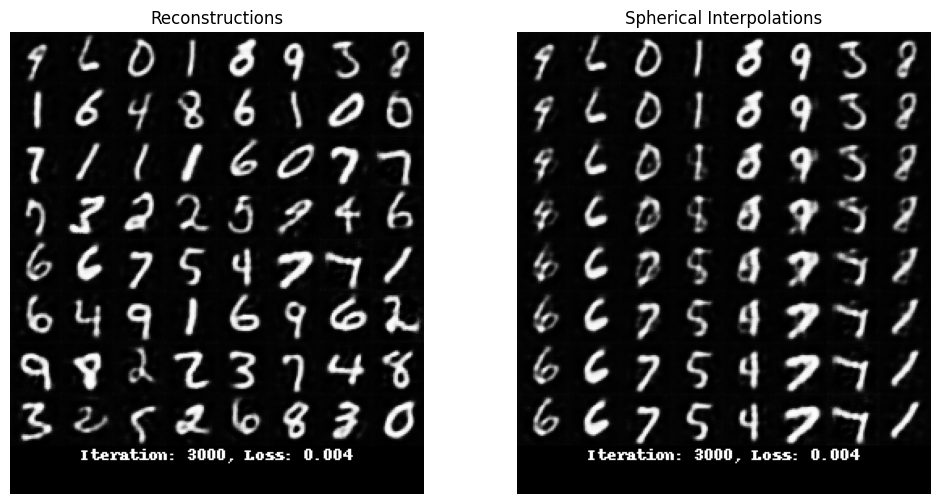

In [38]:
iterations_mnist = []
loss_values_mnist = []

for iteration in range(3001):
    # Sample a batch of data
    real_images, _ = next(data_iterator)
    real_images = real_images.to(device)

    # Compute gradients of the inner loss with respect to zeros (gradient origin)
    latent_points = torch.zeros(batch_sz, latent_dim, 1, 1).to(device).requires_grad_()
    generated_images = G(latent_points)
    inner_loss = ((generated_images - real_images) ** 2).sum(1).mean()
    gradients = torch.autograd.grad(inner_loss, [latent_points], create_graph=True, retain_graph=True)[0]
    latent_points = -gradients

    # Optimize the data fitting loss
    generated_images = G(latent_points)
    outer_loss = ((generated_images - real_images) ** 2).sum(1).mean()
    optimizer.zero_grad()
    outer_loss.backward()
    optimizer.step()

    if iteration % 50 == 0 and iteration > 0:
        print(f"Iteration: {iteration}   Loss: {outer_loss.item():.3f}")
        iterations_mnist.append(iteration)
        loss_values_mnist.append(outer_loss.item())


        # Save reconstructions and interpolations
        reconstructions = torchvision.utils.make_grid(torch.clamp(generated_images, 0, 1), padding=0, nrow=8)
        interpolations = torchvision.utils.make_grid(torch.clamp(generate_slerp_images(G, latent_points.data), 0, 1), padding=0, nrow=8)

        # Convert to PIL images
        recon_image = torchvision.transforms.ToPILImage()(reconstructions.cpu())
        slerp_image = torchvision.transforms.ToPILImage()(interpolations.cpu())

        # Draw iteration number and loss below the images
        recon_text = f'Iteration: {iteration}, Loss: {outer_loss.item():.3f}'
        slerp_text = f'Iteration: {iteration}, Loss: {outer_loss.item():.3f}'

        recon_image = overlay_text(recon_image, recon_text)
        slerp_image = overlay_text(slerp_image, slerp_text)

        # Save images
        recon_image.save(f'generated_recons_mnist/iteration_{iteration:04d}.png')
        slerp_image.save(f'generated_slerps_mnist/iteration_{iteration:04d}.png')

        # Display reconstructions and interpolations
        clear_output()
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title('Reconstructions')
        plt.imshow(np.array(recon_image))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Spherical Interpolations')
        plt.imshow(np.array(slerp_image))
        plt.axis('off')

        plt.show()
        sleep(1)

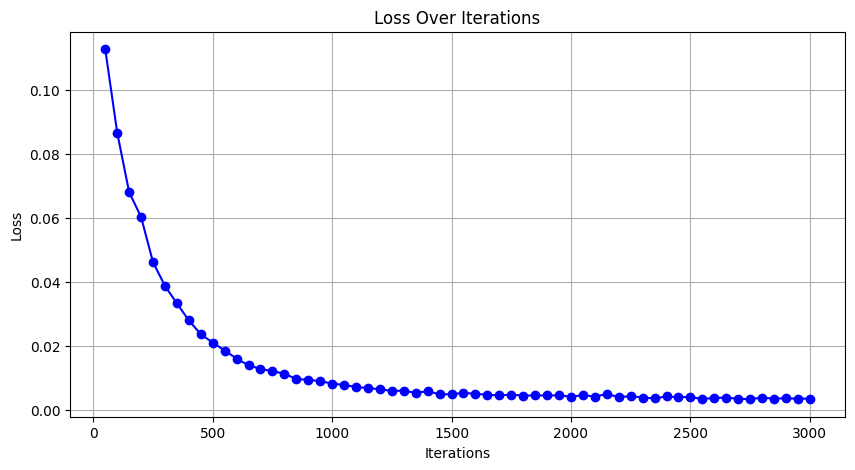

In [39]:
# Plot the loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(iterations_mnist, loss_values_mnist, marker='o', linestyle='-', color='b')
plt.title('Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [40]:
import numpy as np
from PIL import Image, ImageChops

def create_video_from_images(image_folder, video_name, frame_rate=10, transition_frames=10):
    # Collect image files
    images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]

    # Initialize the video writer
    with imageio.get_writer(video_name, fps=frame_rate) as writer:
        previous_image = None

        for filename in images:
            image_path = os.path.join(image_folder, filename)
            current_image = Image.open(image_path)

            # If there's a previous image, generate intermediate frames
            if previous_image:
                for i in range(transition_frames + 1):
                    alpha = i / transition_frames
                    blended_image = Image.blend(previous_image, current_image, alpha)
                    writer.append_data(np.array(blended_image))

            # Add the current image
            writer.append_data(np.array(current_image))
            previous_image = current_image

    print(f"Video saved as {video_name}")

# Create videos for reconstructions and slerps with smooth transitions
create_video_from_images('/content/generated_recons_mnist', 'recons_mnist.mp4', frame_rate=15, transition_frames=2)
create_video_from_images('/content/generated_slerps_mnist', 'slerps_mnist.mp4', frame_rate=15, transition_frames=2)

Video saved as recons_mnist.mp4
Video saved as slerps_mnist.mp4


In [41]:
from IPython.display import Video

# Display the video
Video('recons_mnist.mp4', embed=True)
#Video('slerps.mp4', embed=True)

In [42]:
# # Using Python to clear a directory
# import os
# import shutil

# directory = '/content/generated_slerps'  # Replace with your directory path

# # Create the directory if it does not exist
# os.makedirs(directory, exist_ok=True)

# # Clear the directory
# for filename in os.listdir(directory):
#     file_path = os.path.join(directory, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print(f'Failed to delete {file_path}. Reason: {e}')

# Fashion MNIST

In [43]:
# Dataset information
data_name = 'fashion'  # ['mnist', 'fashion']
image_size = 32
channels = 1

# Training settings
learning_rate = 1e-4
batch_sz = 64
latent_dim = 48
feature_maps = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
if data_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
elif data_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

data_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_sz, drop_last=True)
data_iterator = iter(infinite_cycle(data_loader))

In [44]:
G = GNet().to(device)

optimizer = torch.optim.Adam(lr=learning_rate, params=G.parameters())
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(G.parameters()))}')

# Create directories for saving frames
os.makedirs('generated_recons_fashion', exist_ok=True)
os.makedirs('generated_slerps_fashion', exist_ok=True)

# Define canvas size
canvas_w = 256  # Width of the canvas
canvas_h = 286  # Height of the canvas (extra space for text)

# Function to draw text below an image
def overlay_text(image, text):
    # Create a new image with fixed canvas size and extra space for text
    canvas = Image.new('RGB', (canvas_w, canvas_h), (0, 0, 0))
    image = image.resize((canvas_w, canvas_w))  # Resize image to fit canvas
    canvas.paste(image, (0, 0))

    # Draw the text
    draw = ImageDraw.Draw(canvas)
    font = ImageFont.load_default()
    text_size = draw.textsize(text, font)
    text_position = ((canvas.width - text_size[0]) // 2, canvas_w)  # Centered below the image
    draw.text(text_position, text, fill="white", font=font)

    return canvas

> Number of parameters 263329


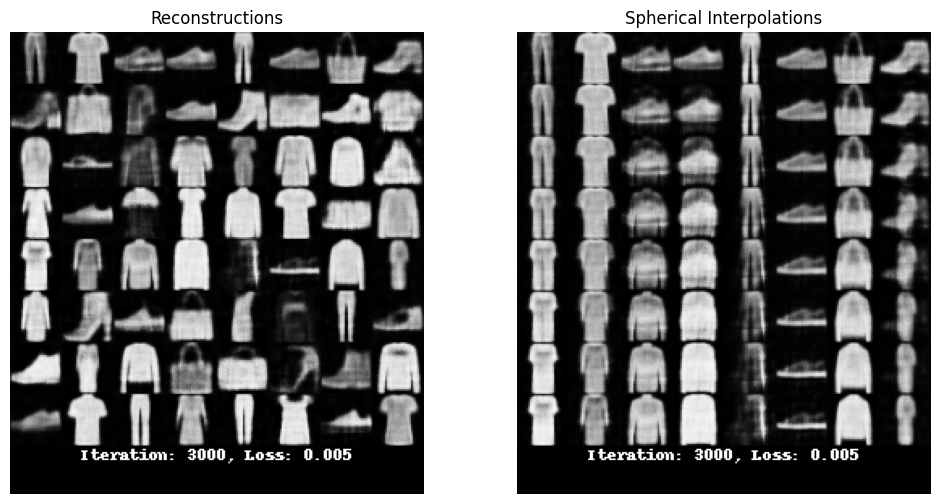

In [45]:
iterations_fashion = []
loss_values_fashion = []

for iteration in range(3001):
    # Sample a batch of data
    real_images, _ = next(data_iterator)
    real_images = real_images.to(device)

    # Compute gradients of the inner loss with respect to zeros (gradient origin)
    latent_points = torch.zeros(batch_sz, latent_dim, 1, 1).to(device).requires_grad_()
    generated_images = G(latent_points)
    inner_loss = ((generated_images - real_images) ** 2).sum(1).mean()
    gradients = torch.autograd.grad(inner_loss, [latent_points], create_graph=True, retain_graph=True)[0]
    latent_points = -gradients

    # Optimize the data fitting loss
    generated_images = G(latent_points)
    outer_loss = ((generated_images - real_images) ** 2).sum(1).mean()
    optimizer.zero_grad()
    outer_loss.backward()
    optimizer.step()

    if iteration % 50 == 0 and iteration > 0:
        print(f"Iteration: {iteration}   Loss: {outer_loss.item():.3f}")
        iterations_fashion.append(iteration)
        loss_values_fashion.append(outer_loss.item())

        # Save reconstructions and interpolations
        reconstructions = torchvision.utils.make_grid(torch.clamp(generated_images, 0, 1), padding=0, nrow=8)
        interpolations = torchvision.utils.make_grid(torch.clamp(generate_slerp_images(G, latent_points.data), 0, 1), padding=0, nrow=8)

        # Convert to PIL images
        recon_image = torchvision.transforms.ToPILImage()(reconstructions.cpu())
        slerp_image = torchvision.transforms.ToPILImage()(interpolations.cpu())

        # Draw iteration number and loss below the images
        recon_text = f'Iteration: {iteration}, Loss: {outer_loss.item():.3f}'
        slerp_text = f'Iteration: {iteration}, Loss: {outer_loss.item():.3f}'

        recon_image = overlay_text(recon_image, recon_text)
        slerp_image = overlay_text(slerp_image, slerp_text)

        # Save images
        recon_image.save(f'generated_recons_fashion/iteration_{iteration:04d}.png')
        slerp_image.save(f'generated_slerps_fashion/iteration_{iteration:04d}.png')

        # Display reconstructions and interpolations
        clear_output()
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.title('Reconstructions')
        plt.imshow(np.array(recon_image))
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title('Spherical Interpolations')
        plt.imshow(np.array(slerp_image))
        plt.axis('off')

        plt.show()
        sleep(1)

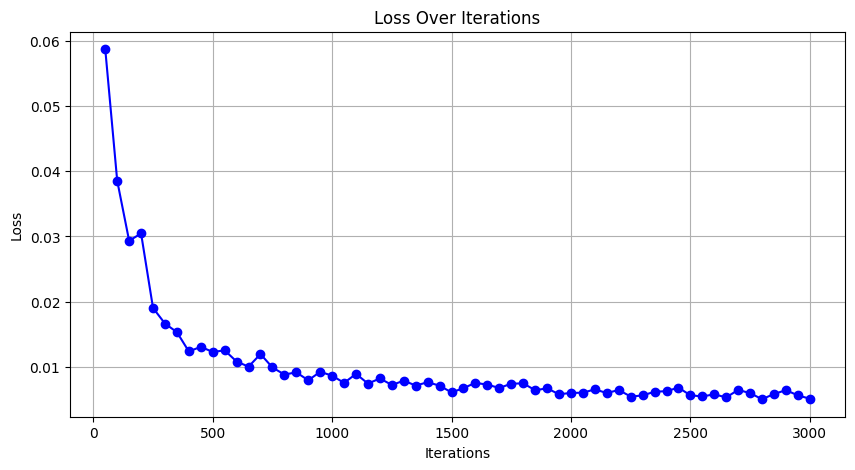

In [46]:
# Plot the loss over iterations
plt.figure(figsize=(10, 5))
plt.plot(iterations_fashion, loss_values_fashion, marker='o', linestyle='-', color='b')
plt.title('Loss Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [47]:
import numpy as np
from PIL import Image, ImageChops

def create_video_from_images(image_folder, video_name, frame_rate=10, transition_frames=10):
    # Collect image files
    images = [img for img in sorted(os.listdir(image_folder)) if img.endswith(".png")]

    # Initialize the video writer
    with imageio.get_writer(video_name, fps=frame_rate) as writer:
        previous_image = None

        for filename in images:
            image_path = os.path.join(image_folder, filename)
            current_image = Image.open(image_path)

            # If there's a previous image, generate intermediate frames
            if previous_image:
                for i in range(transition_frames + 1):
                    alpha = i / transition_frames
                    blended_image = Image.blend(previous_image, current_image, alpha)
                    writer.append_data(np.array(blended_image))

            # Add the current image
            writer.append_data(np.array(current_image))
            previous_image = current_image

    print(f"Video saved as {video_name}")

# Create videos for reconstructions and slerps with smooth transitions
create_video_from_images('/content/generated_recons_fashion', 'recons_fashion.mp4', frame_rate=15, transition_frames=2)
create_video_from_images('/content/generated_slerps_fashion', 'slerps_fashion.mp4', frame_rate=15, transition_frames=2)

Video saved as recons_fashion.mp4
Video saved as slerps_fashion.mp4


In [48]:
from IPython.display import Video

# Display the video
Video('recons_fashion.mp4', embed=True)
#Video('slerps.mp4', embed=True)